In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed

import warnings

In [2]:
plt.rcParams['figure.figsize'] = (10,4)
sns.set()
warnings.filterwarnings('ignore')

In [4]:
path = '/content/drive/MyDrive/nyc_taxi.csv'
data = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [5]:
period = 48
print(data.index[:period])

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               '2014-07-01 05:00:00', '2014-07-01 05:30:00',
               '2014-07-01 06:00:00', '2014-07-01 06:30:00',
               '2014-07-01 07:00:00', '2014-07-01 07:30:00',
               '2014-07-01 08:00:00', '2014-07-01 08:30:00',
               '2014-07-01 09:00:00', '2014-07-01 09:30:00',
               '2014-07-01 10:00:00', '2014-07-01 10:30:00',
               '2014-07-01 11:00:00', '2014-07-01 11:30:00',
               '2014-07-01 12:00:00', '2014-07-01 12:30:00',
               '2014-07-01 13:00:00', '2014-07-01 13:30:00',
               '2014-07-01 14:00:00', '2014-07-01 14:30:00',
               '2014-07-01 15:00:00', '2014-07-01 15:30:00',
               '2014-07-

In [6]:
print('From  ' + str(np.min(data.index)) + '  to  ' +str(np.max(data.index)))


From  2014-07-01 00:00:00  to  2015-01-31 23:30:00


In [7]:
print('Data size: %d \nNumber of data per day: %d \nNumber of days: %d' %(data.shape[0], period, data.shape[0] / period))


Data size: 10320 
Number of data per day: 48 
Number of days: 215


In [8]:
print('Missing value: ', data.isnull().to_numpy().sum())


Missing value:  0


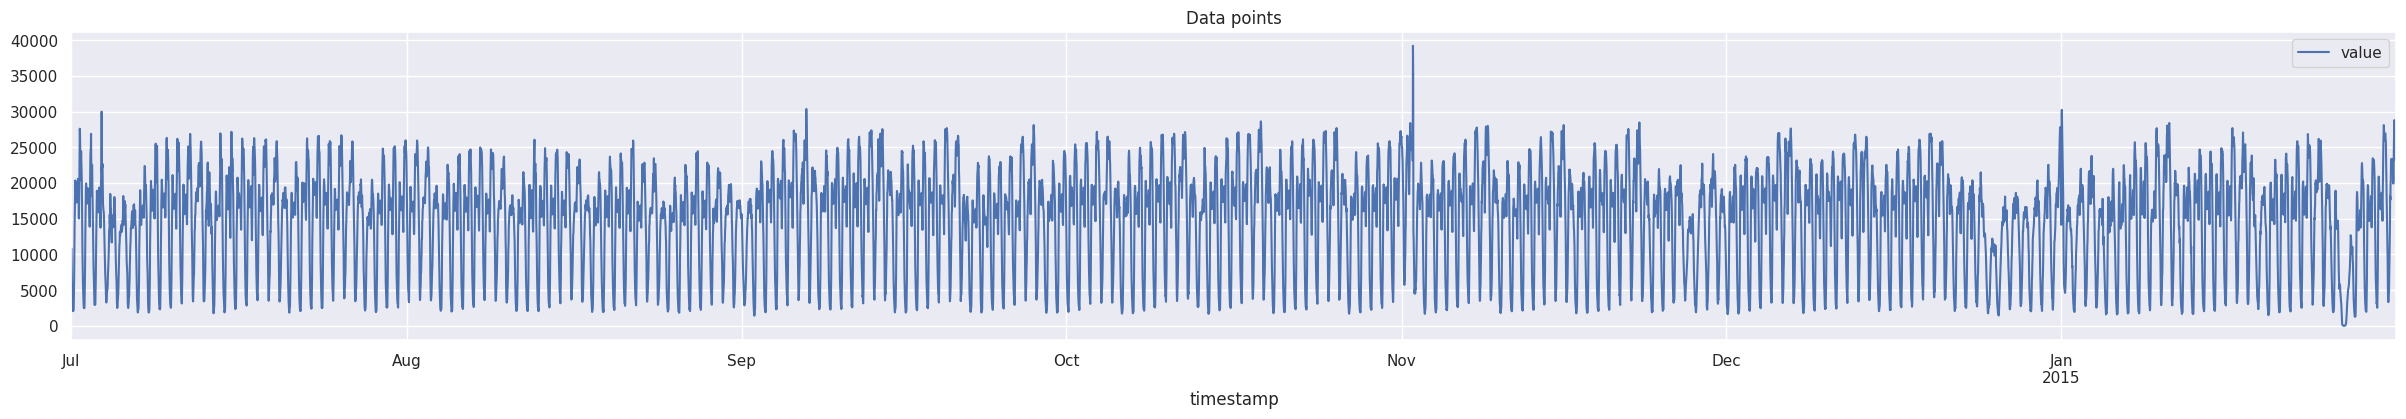

In [9]:
data.plot(title='Data points', figsize=(30,4))
plt.show()

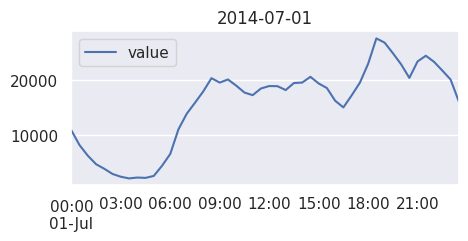

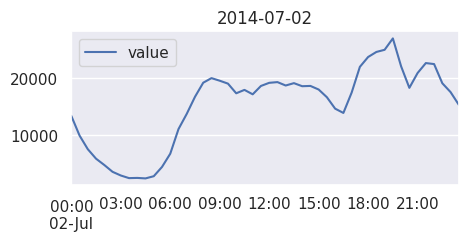

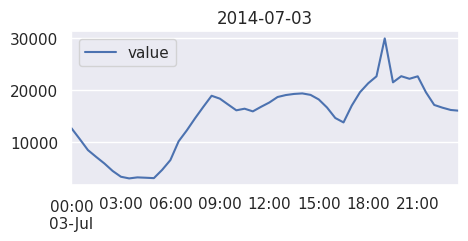

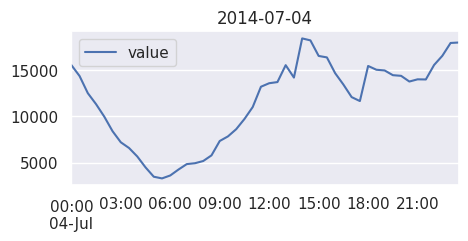

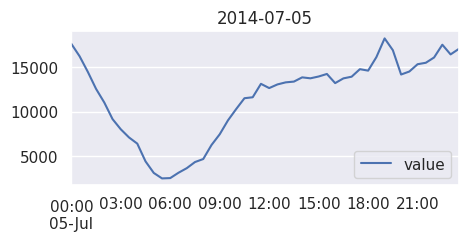

In [10]:
for i in range(5):
    data[period*i:period*(i + 1)].plot(figsize=(5, 2), title=str(data.index[period * i])[:10])
    plt.xlabel(None)
    plt.show()

In [13]:
from sklearn.model_selection import TimeSeriesSplit

# Shuffle the data
data_shuffled = data.sample(frac=1, random_state=42)  # Shuffle the data using a fixed random state

# Define the ratio for training data
ratio = 0.7  # 70% of the data for training

# Split the shuffled data into training and test sets
train_size = int(data_shuffled.shape[0] * ratio)
train = data_shuffled[:train_size]
test = data_shuffled[train_size:]

# Extract dates for train and test sets
dates_train = train.index
dates_test = test.index

# Print information about train and test sets
print('Train size: ', ratio)
print('\n TRAIN SET')
print('Data size: ', train.shape[0])
print('Number of days: ', int(train.shape[0] / period))

print('\n TEST SET')
print('Data size: ', test.shape[0])
print('Number of days: ', int(test.shape[0] / period))


Train size:  0.7

 TRAIN SET
Data size:  7223
Number of days:  150

 TEST SET
Data size:  3097
Number of days:  64


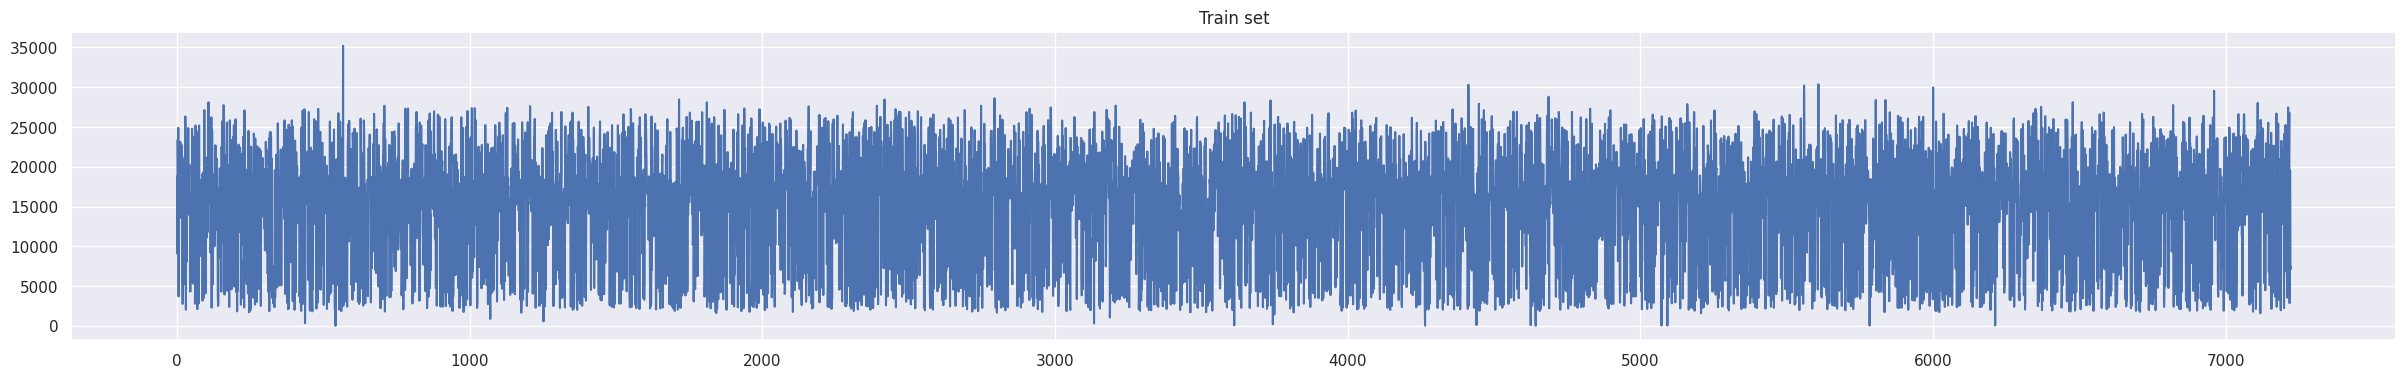

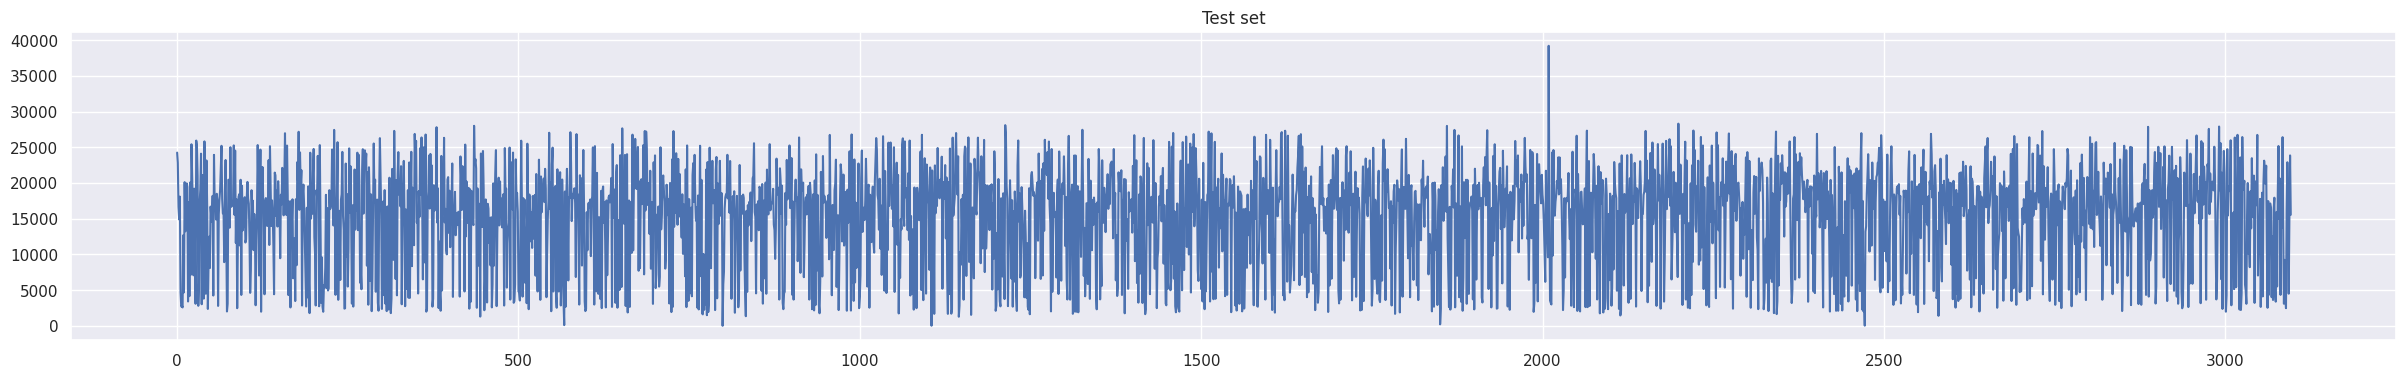

In [14]:
#plots
plt.figure(figsize=(30,4))
plt.title('Train set')
plt.plot(train.to_numpy().flatten())
plt.show()

plt.figure(figsize=(30,4))
plt.title('Test set')
plt.plot(test.to_numpy().flatten())
plt.show()

In [15]:
scaler = StandardScaler()
scaler = scaler.fit(train.values.reshape(-1, 1))

train = scaler.transform(train.values.reshape(-1, 1))
test = scaler.transform(test.values.reshape(-1, 1))

In [16]:
def split_into_windows(X, length):
    windows = []
    num_windows = len(X) - length + 1
    for start in range(num_windows):
        window = X[start:start + length]
        windows.append(window)
    return np.array(windows)

window_length = 48
X_train = split_into_windows(train, window_length)
X_test = split_into_windows(test, window_length)


In [20]:
_, input_length, input_dim = X_train.shape
X_train.shape

(7176, 48, 1)

In [21]:
# params
dim_hidden1 = 24 # 1/2 the length of one window
dim_hidden2 = 12 # 1/4 the length of one window


# model
model = Sequential()
model.add(LSTM(units=dim_hidden1, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden1, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))

# summary
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 24)            2496      
                                                                 
 dropout (Dropout)           (None, 48, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 12)            1776      
                                                                 
 dropout_1 (Dropout)         (None, 48, 12)            0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 12)            1200      
                                                                 
 dropout_2 (Dropout)         (None, 48, 12)            0         
                                                                 
 lstm_3 (LSTM)               (None, 48, 24)           

In [22]:
# params
batch_size = 48 # 24 hours == length of the window
epochs = 50
validation_split = 0.1
es = EarlyStopping(monitor='val_loss', patience=5)


# fitting
history = model.fit(X_train, X_train,
                batch_size = batch_size,
                epochs = epochs,
                validation_split = validation_split,
                callbacks = [es])

Epoch 1/50
135/135 [==============================] - 16s 83ms/step - loss: 0.9815 - val_loss: 0.5818
Epoch 2/50
135/135 [==============================] - 9s 64ms/step - loss: 0.4238 - val_loss: 0.1198
Epoch 3/50
135/135 [==============================] - 9s 66ms/step - loss: 0.1829 - val_loss: 0.0708
Epoch 4/50
135/135 [==============================] - 9s 70ms/step - loss: 0.1279 - val_loss: 0.0436
Epoch 5/50
135/135 [==============================] - 8s 62ms/step - loss: 0.1036 - val_loss: 0.0403
Epoch 6/50
135/135 [==============================] - 9s 67ms/step - loss: 0.0894 - val_loss: 0.0271
Epoch 7/50
135/135 [==============================] - 9s 70ms/step - loss: 0.0807 - val_loss: 0.0259
Epoch 8/50
135/135 [==============================] - 8s 61ms/step - loss: 0.0747 - val_loss: 0.0240
Epoch 9/50
135/135 [==============================] - 9s 68ms/step - loss: 0.0701 - val_loss: 0.0225
Epoch 10/50
135/135 [==============================] - 9s 70ms/step - loss: 0.0662 - val_l

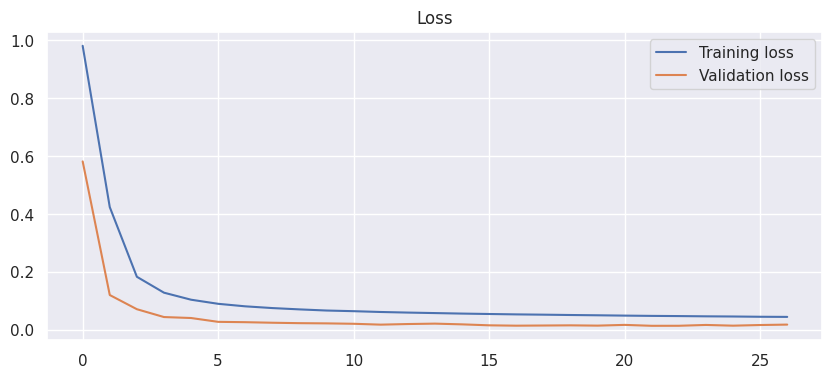

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [24]:
pred_x_test = model.predict(X_test)
pred_x_train = model.predict(X_train)

225/225 [==============================] - 3s 14ms/step


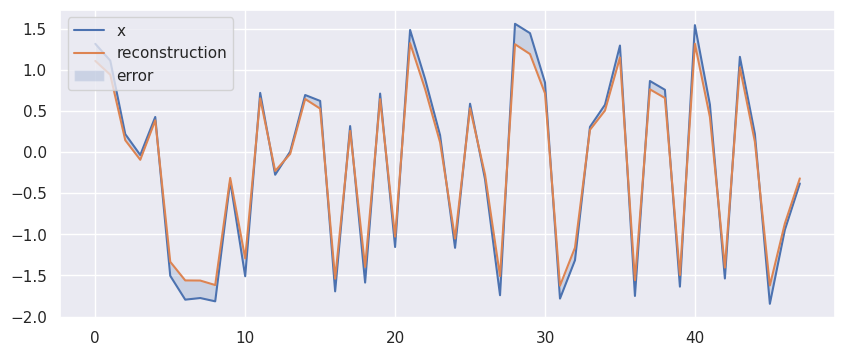

In [25]:
for i in range(int(period / window_length)):
    x = X_test[i * window_length].flatten()
    x_pred = pred_x_test[i * window_length].flatten()

    plt.plot(x, label='x')
    plt.plot(x_pred, label='reconstruction')
    plt.fill_between(np.arange(window_length), x, x_pred, alpha=0.2, label='error')
    plt.legend()
    plt.show()

In [26]:
mse = lambda x, x_pred: np.mean(np.abs(x - x_pred)**2, axis=1)

train_mae_loss = pd.DataFrame(mse(X_train, pred_x_train), columns=['Error'])
test_mae_loss = pd.DataFrame(mse(X_test, pred_x_test), columns=['Error'])

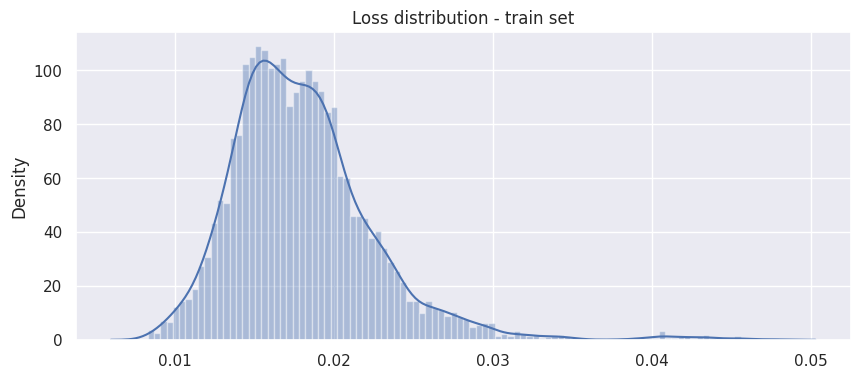

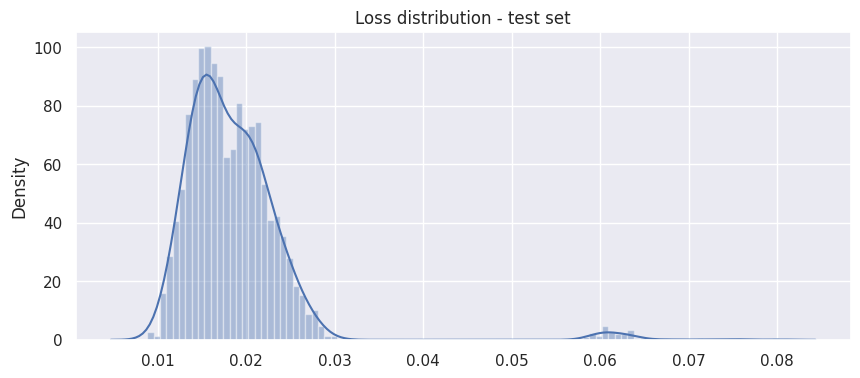

In [27]:
plt.title('Loss distribution - train set')
sns.distplot(train_mae_loss, bins=100, kde=True)
plt.show()

plt.title('Loss distribution - test set')
sns.distplot(test_mae_loss, bins=100, kde=True)
plt.show()

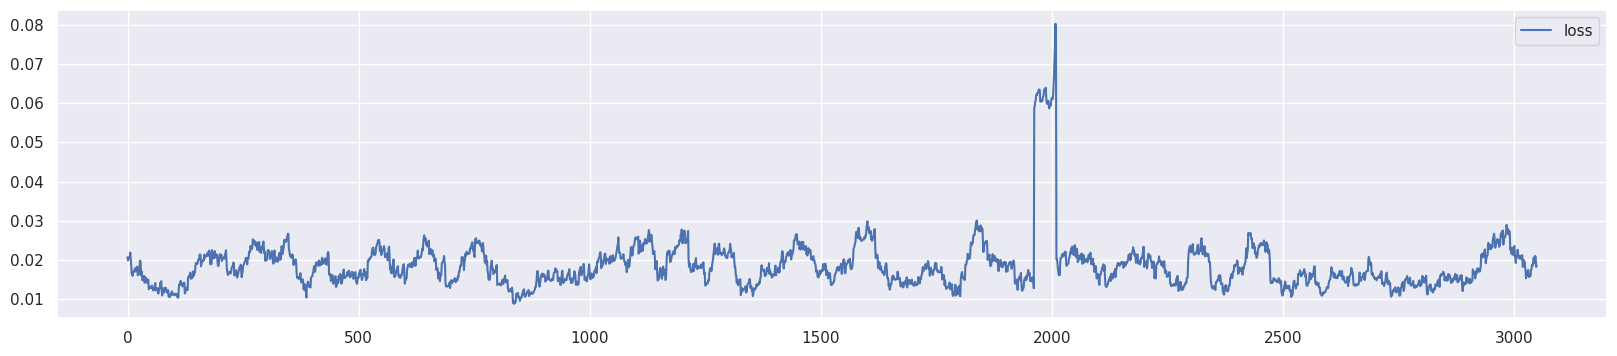

In [28]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()

plt.figure(figsize=(20,4))
plt.plot(test_mae_loss_array, label='loss')
plt.legend()
plt.show()

In [29]:
print(np.mean(test_mae_loss)[0] + 2 * np.std(test_mae_loss)[0])


0.03236741379905325


In [33]:
threshold = 0.025


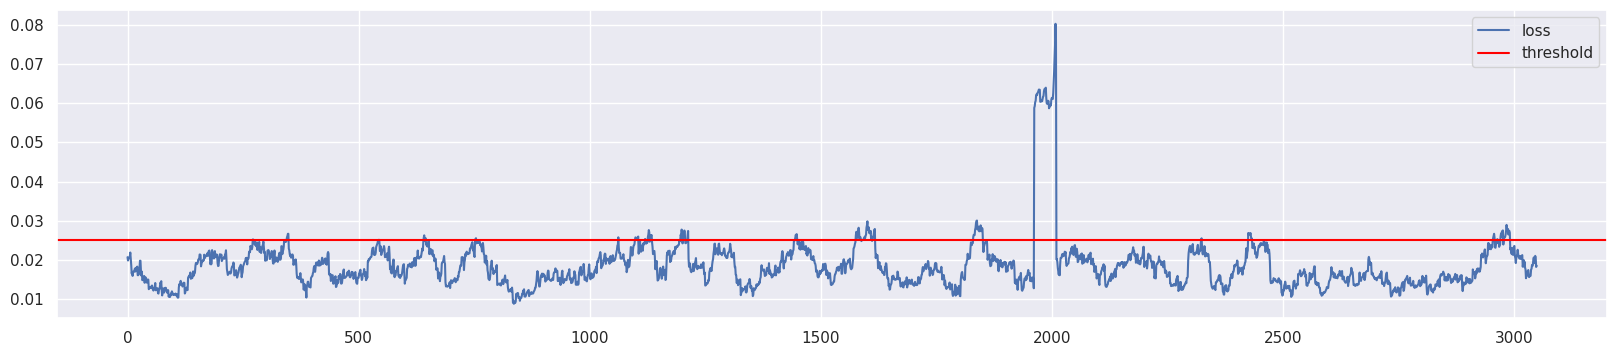

In [34]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()


plt.figure(figsize=(20,4))
plt.plot(test_mae_loss_array, label='loss')
plt.axhline(threshold, color='red', label='threshold')
plt.legend()
plt.show()

In [35]:
y_pred = test_mae_loss_array >= threshold
y_pred.shape

(3050,)

In [36]:
dates_test[:-(window_length-1)].shape


(3050,)

In [37]:
dates_with_hours_anomalies = dates_test[:-(window_length-1)][y_pred]

print('Dates where anomalies have been detected:')
for d in dates_with_hours_anomalies:
    print(d)

Dates where anomalies have been detected:
2014-08-19 21:30:00
2014-07-31 19:00:00
2014-12-21 06:30:00
2014-08-17 06:30:00
2015-01-07 00:00:00
2014-10-11 10:00:00
2014-10-19 21:00:00
2014-10-29 06:30:00
2014-11-07 20:00:00
2014-09-21 11:00:00
2014-10-12 17:30:00
2014-12-17 03:00:00
2014-11-13 23:00:00
2015-01-30 05:00:00
2014-07-19 05:00:00
2014-08-17 20:30:00
2014-08-25 01:30:00
2014-10-11 22:00:00
2014-11-03 18:00:00
2014-10-08 23:00:00
2015-01-02 20:30:00
2014-10-04 16:00:00
2014-07-04 09:30:00
2015-01-28 19:30:00
2015-01-19 19:00:00
2015-01-27 04:30:00
2014-11-05 22:00:00
2014-12-11 16:30:00
2014-09-07 19:00:00
2014-10-03 02:30:00
2015-01-12 03:30:00
2014-07-30 05:30:00
2014-07-29 19:00:00
2014-11-22 08:00:00
2014-10-27 03:30:00
2014-10-22 05:30:00
2014-07-31 01:00:00
2014-09-30 19:00:00
2015-01-21 22:00:00
2014-08-05 04:30:00
2015-01-29 02:30:00
2014-11-02 05:00:00
2014-08-22 00:00:00
2014-12-24 07:00:00
2014-07-08 02:00:00
2014-08-20 04:00:00
2014-07-22 02:00:00
2014-10-19 00:00:0

In [38]:
indexes = []
for d in dates_with_hours_anomalies:
    index_low = np.where(dates_test == d)
    d_temp = d  + np.timedelta64(int(window_length / 2), 'h')
    indexes.append(index_low[0][0])

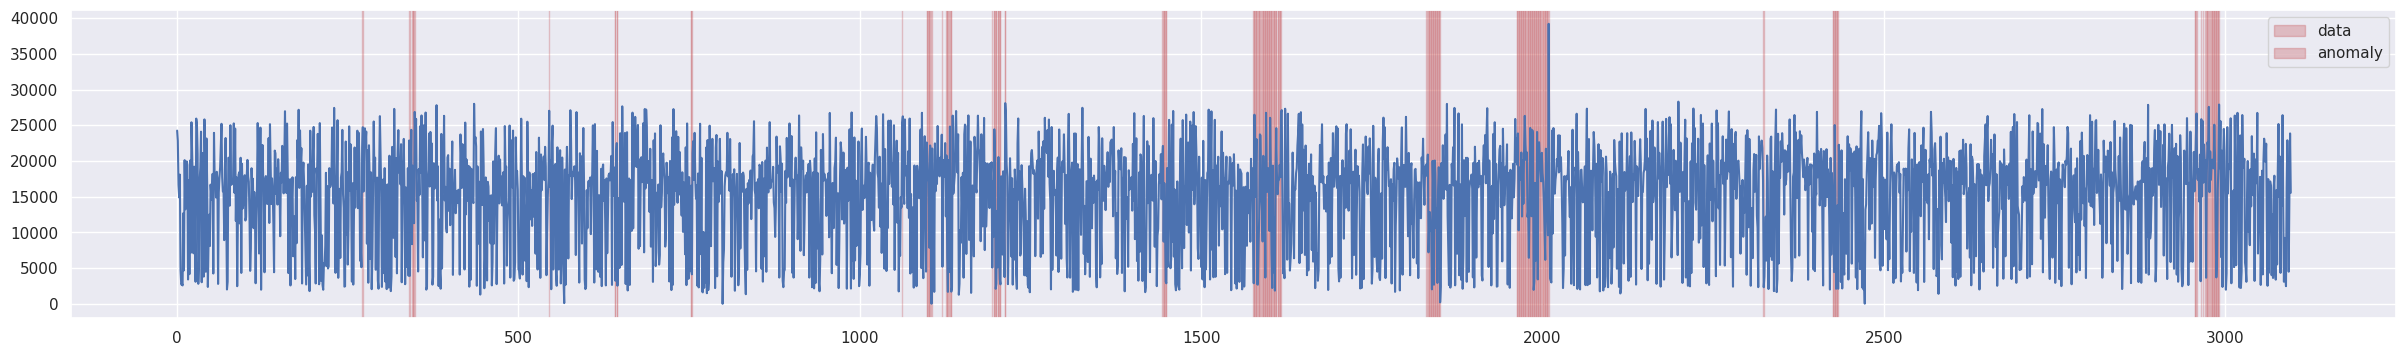

In [39]:
plt.figure(figsize=(30,4))
for index in indexes:
    plt.axvspan(index, index, color='r', alpha=0.3)
plt.plot(scaler.inverse_transform(test).flatten())
plt.legend(['data', 'anomaly'])
plt.show()